### Job description screening by NLP
Chiyuan Cheng
- objective:
  - load job description in google sheet and find the matching keywords by NLP
  - A small project for information extraction


#### Python package

In [0]:
#importing all required libraries
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
import os
from os import listdir
from os.path import isfile, join
from io import StringIO

# NLP package
import re
import string
import spacy #use NLP functions
from spacy import displacy
import en_core_web_sm # pre-train model
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher
import nltk #NLP data processing library (IMDB)
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phraser, Phrases # phraser optimizes phrases
# ML package
from keras.preprocessing.text import one_hot # relation
from textblob import TextBlob
from sklearn.manifold import TSNE
from keras.preprocessing.text import one_hot # relation
from collections import Counter
# general package
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure


In [26]:
!pip install inflection
import inflection as inf

  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6076 sha256=8df5159d6866b6a4cb3a363cb63e1568370e88ff917b72146322793c9e9c2f99
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection


#### Load data

In [0]:
# load data from google sheet
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1_7xr5Wfe1Zxz31fRAg4HxM7579p7pLyv2DQeynqAeNQ/edit?folder=1Zdk9qp8mD6x93sdLr14SMf-iczSrlrsP#gid=0')

In [0]:
def load_googlesheet(sheetname):
  '''
  input sheetname
  output pd.dataframe
  '''
  sheet = wb.worksheet(sheetname) # sheet name
  data = sheet.get_all_values() # load sheet
  df = pd.DataFrame(data)
  df.columns = df.iloc[0]
  df = df.iloc[1:]
  df=df.reset_index(drop=True)
  return df

In [0]:
# data for job discription
df_jd = load_googlesheet('Sheet1')
# data for keywords
df_kw = load_googlesheet('keywords')

In [18]:
display(df_jd.head(3))
display(df_kw.head(3))

,Financial,Healthcare,e-com,social media,consumer,Information
0,"Two Sigma, The Alpha Insights team at Two Sigm...","Novo Nordisk, The Clinical, Medical and Regula...",Walmart \nA Staff Data Scientist is responsibl...,"Facebook, We’re looking for Data Scientists to...","Uniliever, Background & Purpose of the Job\n\n...","Google, Note: By applying to this position you..."
1,"Prudential Financial,\n\nAs we create a divers...","Aetna, Description:\nIt’s a new day in health ...","Walmart, As a part of Walmart’s Customer Data ...","Facebook, With over 2.1 billion people, our co...","Verizon, What you’ll be doing...\n\nAs a data ...","Taped, Small Teams; Big Data\n\nWe are looking..."
2,Machine Learning Research Scientist - Pattern ...,Health is a well-funded healthcare technolog...,Amazon\n\nAre you seeking an environment where...,"New York Times, The New York Times is a techno...","Colgate, \n\nDevelop data-driven approaches an...","At Bonobos, we’re redefining how customers bro..."


,statistics,machine learning,deep learning,python langugage,R language,nlp,data engineering,cloud,visualization,soft skills,computer vision,Degree
0,statistical models,linear regression,neural network,flask,R,natural language processing,,aws,matplotlib,Communication,computer vision,Bachelor
1,statistical modeling,logestic regression,keras,pandas,ggplot,topic modeling,transform,ecs,seaborn,experience,image,Master
2,probability,k means,theano,numpy,shiny,lda,extraction,redshift,visualization,outside the box,imaging,phd


#### Text Preprocessing

In [0]:
df_clean = df_jd.copy()

In [0]:
def rm_punc_lc(data):
  '''
  remove punctuations and conver to lowercase
  '''
  result_punctuation = string.punctuation + str('\n') + str('\r')
  for names in data.columns:
    for i in range(data[names].shape[0]):
      for char in data[names][i]:
        if char in result_punctuation:
          data[names][i] = data[names][i].replace(char, " ")
      data[names][i] = data[names][i].lower()#
  return data

In [21]:
df_jd_clean = rm_punc_lc(df_jd)
df_jd_clean.head()

,Financial,Healthcare,e-com,social media,consumer,Information
0,two sigma the alpha insights team at two sigm...,novo nordisk the clinical medical and regula...,walmart a staff data scientist is responsible...,facebook we’re looking for data scientists to...,uniliever background purpose of the job as...,google note by applying to this position you...
1,prudential financial as we create a diverse ...,aetna description it’s a new day in health c...,walmart as a part of walmart’s customer data ...,facebook with over 2 1 billion people our co...,verizon what you’ll be doing as a data sc...,taped small teams big data we are looking f...
2,machine learning research scientist pattern ...,health is a well funded healthcare technolog...,amazon are you seeking an environment where y...,new york times the new york times is a techno...,colgate develop data driven approaches and ...,at bonobos we’re redefining how customers bro...
3,venmo was founded on the principles of breaki...,oscar hi we re oscar we re hiring a data sc...,amazon description amazon is looking for a p...,wolters kluwer data scientist – r0006015 wol...,as a data scientist you ll utilize advanced q...,
4,sofi sofi is a digital personal finance compa...,oscar hi we re oscar we re hiring a data sc...,amazon where will amazon s growth come from i...,bloomberg news and social media move financia...,,


In [0]:
# singularize
import inflection as inf
for i in range(df_jd_clean.shape[1]):
  df_jd_clean.iloc[:,i] = df_jd_clean.iloc[:,i].apply(lambda x: ' '.join([inf.singularize(item) for item in x.split()]))

In [77]:
df_jd_clean.iloc[1,0]

'prudential financial a we create a diverse growing and dynamic workforce within a technology community that respected for delivering high tech solution datum driven solution are at the core of it all to thi end isg technology i seeking a qualified senior datum scientist with experience in designing solution to business problem using machine learning big datum technique and technology the ideal candidate i a datum driven problem solver with an ability to translate business requirement into mathematical model the candidate will also have an ability to develop solution to complex mathematical and datum problem discover insight and identify opportunity through the use of statistical algorithmic datum mining and visualization technique partnering with a team of technology and business datum specialist the candidate will use their analytic and engineering skill to integrate and prepare large varied dataset and architecting specialized solution in cloud environment employing a range of machi

In [0]:
# clean text

def clean_text(text):
    """
        text: a string of the spouse column
        return: modified initial string
    """

 
    text = re.sub(r"datum driven", " data-driven", text)
    text = re.sub(r"datum", " data", text)
    text = re.sub(r"metric", "metrics", text)
    text = re.sub(r"statistic", "statistics", text)
    text = re.sub(r"datum mining", "data-mining", text)
    text = re.sub(r"his death", " de ", text)
    text = re.sub(r"died", " de ", text)
    
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [34]:
df_kw_clean = rm_punc_lc(df_kw)
df_kw_clean.head()

,statistics,machine learning,deep learning,python langugage,R language,nlp,data engineering,cloud,visualization,soft skills,computer vision,Degree
0,statistical models,linear regression,neural network,flask,r,natural language processing,,aws,matplotlib,communication,computer vision,bachelor
1,statistical modeling,logestic regression,keras,pandas,ggplot,topic modeling,transform,ecs,seaborn,experience,image,master
2,probability,k means,theano,numpy,shiny,lda,extraction,redshift,visualization,outside the box,imaging,phd
3,normal distribution,random forest,neural networks,scikitlearn,cran,named entity recognition,,s3,eda,problem solver,,
4,survival models,xgboost,convolutional neural network,sklearn,dplyr,pos tagging,docker,hadoop,tableau,problem solving,,


#### stop words

In [35]:
# print stop words from spacy
nlp = en_core_web_sm.load()  # spacy language model
stop_words = list(spacy.lang.en.stop_words.STOP_WORDS) #+ list(string.punctuation) 
stop_words.append('two')
print(stop_words)
print('numbers of stopwords =',len(stop_words))

['via', 'an', 'more', 'whence', 'over', 'mine', 'empty', 'somewhere', 'towards', 'we', 'well', 'per', 'were', 'her', '’ll', 'around', 'afterwards', 'whole', 'regarding', 'further', 'see', 'been', 'side', 'up', "'ve", 'next', 'put', 'make', 'please', 'least', 'become', 'our', 'rather', 'moreover', 'when', 'him', 'toward', 'nor', 'both', 'between', 'made', 'a', 'yours', 'or', 'six', 'along', 'even', 'since', 'yourselves', 'always', 'did', 'third', 'else', 'eleven', 'the', 'other', 'whither', 'himself', 'own', 'do', 'thereupon', 'twelve', 'everywhere', 'various', 'alone', 'there', 'using', 'anyhow', 'amount', 'never', 'became', 'thereafter', 'nevertheless', 'together', 'seeming', 'unless', 'but', 'others', 'n‘t', 'these', 'bottom', "'re", 'no', 'than', 'most', 'noone', 'how', 'call', 'everything', 'otherwise', 'she', 'used', '’s', 'give', 'doing', 'on', 'what', 'get', 'someone', 'perhaps', 'anything', 'not', 'are', 'hereafter', '‘ll', 'anywhere', 'nothing', 'them', 'ourselves', 'herself',

In [0]:
def filter_stop_word(data, column=0):
  sent_no_stop=[]
  for i in range(df_jd_clean.shape[0]):
    for w in df_jd_clean.iloc[i,column].split():
      if w not in stop_words:
        sent_no_stop.append(w)
  return sent_no_stop 

In [37]:
df_jd_clean.shape

(16, 6)

In [0]:
# Spell check using text blob (take about 10 mins)
from textblob import TextBlob
for i in range(df_jd_clean.shape[1]):
  df_jd_clean.iloc[:,i].apply(lambda x: str(TextBlob(x).correct()));

In [0]:
words_financial = filter_stop_word(df_jd_clean,0)
words_healthcare = filter_stop_word(df_jd_clean,1)
words_ecom = filter_stop_word(df_jd_clean,2)
words_social = filter_stop_word(df_jd_clean,3)
words_consumer = filter_stop_word(df_jd_clean,4)
words_info = filter_stop_word(df_jd_clean,5)

In [0]:
def check_common_words(data, num):
  '''
  Checking the first 10 most frequent words
  '''
  from collections import Counter
  cnt = Counter()
  for text in data:
    for word in text.split():
      cnt[word] += 1    
  return cnt.most_common(num)

In [40]:
# check common words for financial
check_common_words(words_financial, 20)

[('datum', 120),
 ('experience', 59),
 ('team', 49),
 ('research', 35),
 ('learning', 28),
 ('investment', 27),
 ('product', 27),
 ('work', 27),
 ('insight', 26),
 ('analysis', 26),
 ('business', 25),
 ('analytic', 25),
 ('skill', 24),
 ('machine', 24),
 ('client', 24),
 ('science', 21),
 ('scientist', 20),
 ('year', 20),
 ('technology', 19),
 ('working', 19)]

#### Keyword matching by SpaCY

###### keywords

In [61]:
df_kw_clean.columns

Index(['statistics', 'machine learning', 'deep learning', 'python langugage',
       'R language', 'nlp', 'data engineering', 'cloud', 'visualization',
       'soft skills', 'computer vision ', 'Degree'],
      dtype='object', name=0)

In [0]:
kwords_stats = [nlp(text) for text in df_kw_clean['statistics'].dropna(axis=0)]
kwords_ml = [nlp(text) for text in df_kw_clean['machine learning'].dropna(axis=0)]
kwords_dl = [nlp(text) for text in df_kw_clean['deep learning'].dropna(axis=0)]
kwords_py = [nlp(text) for text in df_kw_clean['python langugage'].dropna(axis=0)]
kwords_r = [nlp(text) for text in df_kw_clean['R language'].dropna(axis=0)]
kwords_nlp = [nlp(text) for text in df_kw_clean['nlp'].dropna(axis=0)]
kwords_de = [nlp(text) for text in df_kw_clean['data engineering'].dropna(axis=0)]
kwords_cloud = [nlp(text) for text in df_kw_clean['cloud'].dropna(axis=0)]
kwords_vis = [nlp(text) for text in df_kw_clean['visualization'].dropna(axis=0)]
kwords_ss = [nlp(text) for text in df_kw_clean['soft skills'].dropna(axis=0)]
kwords_cv = [nlp(text) for text in df_kw_clean['computer vision '].dropna(axis=0)]

In [0]:
matcher = PhraseMatcher(nlp.vocab)
matcher.add('Stats', None, *kwords_stats)
matcher.add('ML', None, *kwords_ml)
matcher.add('DL', None, *kwords_dl)
matcher.add('Py', None, *kwords_py)
matcher.add('R', None, *kwords_r)
matcher.add('NLP', None, *kwords_nlp)
matcher.add('DE', None, *kwords_de)
matcher.add('Cloud', None, *kwords_cloud)
matcher.add('Vis', None, *kwords_vis)
matcher.add('SS', None, *kwords_ss)
matcher.add('CV', None, *kwords_cv)


In [0]:
def match_kw(dataframe, column_name='Financial'):
  '''
  input: datframe and columne name
  output: dataframe with subject and count for keywords
  '''
  # make a list for one column
  d_list = []
  for i in range(dataframe.shape[0]):
    d_list.append(dataframe[column_name][i])#doc = nlp(df_jd['Financial'][0])
  doc = nlp(str(d_list))

  matches = matcher(doc)
  # matching with keyword
  d = []
  for match_id, start, end in matches:
    rule_id = nlp.vocab.strings[match_id]
    span = doc[start:end]
    d.append((rule_id, span.text))
  keywords= "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())

  ## convertimg string of keywords to dataframe
  df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
  df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
  df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
  df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
  df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
  df3['Count'] = df3['Count'].astype(int)

  name = os.path.basename(column_name).lower()

  ## converting str to dataframe
  name1 = pd.read_csv(StringIO(name),names = ['Category'])    
  dataf = pd.concat([name1['Category'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
  dataf['Category'].fillna(dataf['Category'].iloc[0], inplace = True)
  dataf = dataf.sort_values(by=['Count'], ascending=False)
  return dataf

In [66]:
df_jd_clean.columns

Index(['Financial', 'Healthcare', 'e-com', 'social media', 'consumer ',
       'Information'],
      dtype='object', name=0)

In [0]:
df_match_financial = match_kw(df_jd_clean, column_name='Financial')

In [68]:
df_match_financial.head()#.sort_values(by=['Count'], ascending=False).iloc[:10,:]

,Category,Subject,Keyword,Count
5,financial,SS,experience,59
14,financial,ML,machine learning,23
6,financial,Stats,quantitative,18
12,financial,R,r,13
36,financial,Py,python,12


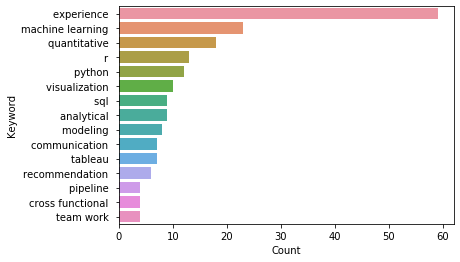

In [69]:
sns.barplot(x="Count", y="Keyword", data=df_match_financial.head(15))

In [70]:
df_match_healthcare = match_kw(df_jd_clean, column_name='Healthcare')
df_match_healthcare.head(10)

,Category,Subject,Keyword,Count
2,healthcare,SS,experience,87
9,healthcare,ML,machine learning,19
11,healthcare,SS,analytical,15
12,healthcare,DE,modeling,14
7,healthcare,Py,python,14
8,healthcare,DE,sql,13
0,healthcare,Vis,visualization,9
6,healthcare,R,r,8
17,healthcare,ML,recommendation,8
21,healthcare,Vis,looker,7


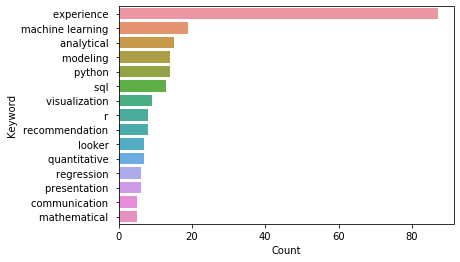

In [71]:

sns.barplot(x="Count", y="Keyword", data=df_match_healthcare.head(15))

,Category,Subject,Keyword,Count
10,e-com,SS,experience,49
11,e-com,ML,machine learning,24
19,e-com,Stats,quantitative,18
22,e-com,Stats,forecasting,16
3,e-com,DE,modeling,14
13,e-com,SS,communication,11
6,e-com,Py,python,10
0,e-com,SS,analytical,8
23,e-com,ML,time series,6
21,e-com,Stats,mathematical,6


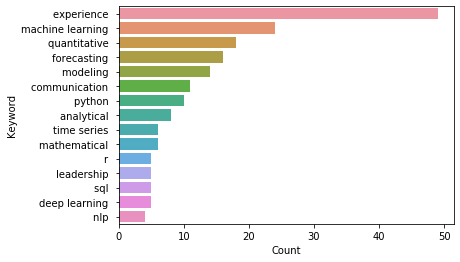

In [72]:
df_match_ecom = match_kw(df_jd_clean, column_name='e-com')
display(df_match_ecom.head(10))

sns.barplot(x="Count", y="Keyword", data=df_match_ecom.head(15))

,Category,Subject,Keyword,Count
1,social media,SS,experience,60
21,social media,ML,machine learning,24
13,social media,Py,python,12
0,social media,Stats,quantitative,10
12,social media,DE,sql,8
17,social media,R,r,7
27,social media,Cloud,spark,6
20,social media,SS,communication,5
39,social media,DE,modeling,5
7,social media,ML,recommendation,5


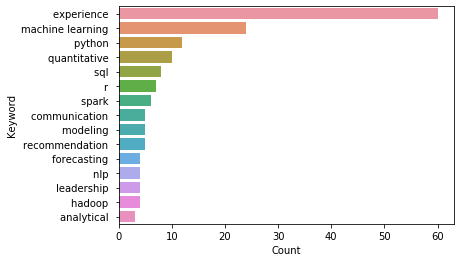

In [73]:
df_match_soc = match_kw(df_jd_clean, column_name='social media')
display(df_match_soc.head(10))

sns.barplot(x="Count", y="Keyword", data=df_match_soc.head(15))

,Category,Subject,Keyword,Count
2,consumer,SS,experience,21
29,consumer,R,r,9
6,consumer,DE,modeling,6
25,consumer,Py,python,6
3,consumer,SS,analytical,5
8,consumer,Vis,visualization,5
28,consumer,DE,sql,5
0,consumer,SS,cross functional,4
4,consumer,Stats,quantitative,4
5,consumer,ML,regression,4


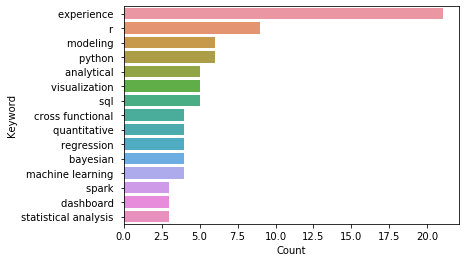

In [74]:
df_match_consumer = match_kw(df_jd_clean, column_name='consumer ')
display(df_match_consumer.head(10))

sns.barplot(x="Count", y="Keyword", data=df_match_consumer.head(15))

,Category,Subject,Keyword,Count
2,information,SS,experience,19
0,information,Cloud,google,7
9,information,ML,machine learning,6
1,information,Stats,quantitative,6
14,information,DE,pipeline,6
5,information,Py,python,4
17,information,DE,modeling,4
21,information,Cloud,spark,3
10,information,Stats,mathematical,3
19,information,ML,clustering,3


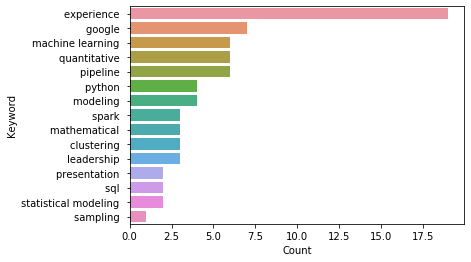

In [75]:

df_match_info = match_kw(df_jd_clean, column_name='Information')
display(df_match_info.head(10))

sns.barplot(x="Count", y="Keyword", data=df_match_info.head(15))

In [0]:
d = []
for match_id, start, end in matches:
  rule_id = nlp.vocab.strings[match_id]
  span = doc[start:end]
  d.append((rule_id, span.text))
keywords= "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())

In [0]:
## convertimg string of keywords to dataframe
df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
df3['Count'] = df3['Count'].astype(int)
    

In [0]:

name = os.path.basename('financial').lower()

## converting str to dataframe
name1 = pd.read_csv(StringIO(name),names = ['Category'])    
dataf = pd.concat([name1['Category'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
dataf['Category'].fillna(dataf['Category'].iloc[0], inplace = True)

In [108]:
dataf.sort_values(by=['Count'], ascending=False).iloc[:10,:]#[dataf['Subject']=='ML']

,Category,Subject,Keyword,Count
8,financial,SS,experience,59
0,financial,SS,insights,26
19,financial,ML,machine learning,23
9,financial,Stats,quantitative,18
17,financial,R,r,13
48,financial,Py,python,12
2,financial,SS,data driven,11
3,financial,DL,metrics,9
68,financial,SS,analytical,9
70,financial,DE,sql,9


In [0]:
#function that does phrase matching and builds a candidate profile
def create_profile(file):
    text = pdfextract(file) 
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = pd.read_csv('D:/NLP_Resume/resume/template_new.csv')
    stats_words = [nlp(text) for text in keyword_dict['Statistics'].dropna(axis = 0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis = 0)]
    ML_words = [nlp(text) for text in keyword_dict['Machine Learning'].dropna(axis = 0)]
    DL_words = [nlp(text) for text in keyword_dict['Deep Learning'].dropna(axis = 0)]
    R_words = [nlp(text) for text in keyword_dict['R Language'].dropna(axis = 0)]
    python_words = [nlp(text) for text in keyword_dict['Python Language'].dropna(axis = 0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['Data Engineering'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)

    return(dataf)

#### Topic Modeling with LSA

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from collections import Counter

In [0]:
reindexed_data = np.array(word_clean(df_clean, 'Healthcare'))
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data#.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [0]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [0]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [0]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [0]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [0]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  data driven addition
Topic 2:  experience datasets text
Topic 3:  analytics oscar analysis
Topic 4:  health models care
Topic 5:  work product business
Topic 6:  new team projects


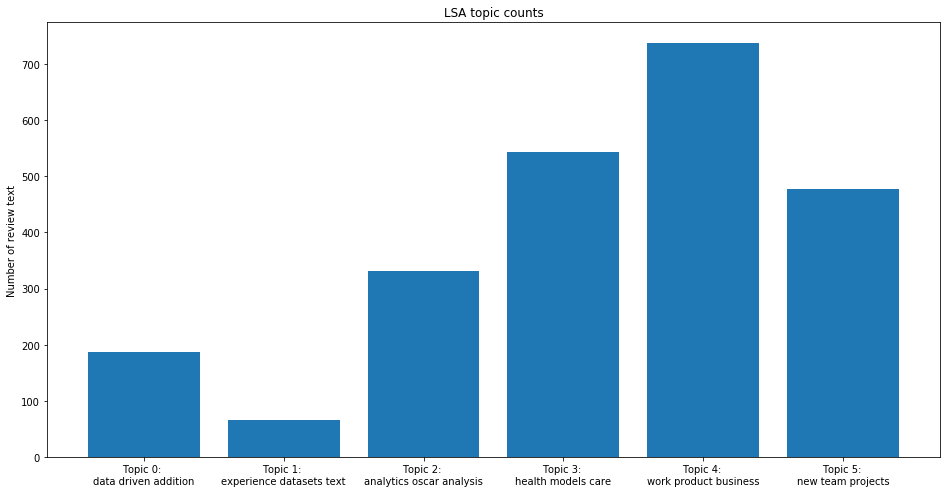

In [0]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();

In [0]:
df_hc = pd.DataFrame(word_clean(df_clean, 'Healthcare'), columns=['names'])

In [0]:
df_hc.head()

,names
0,novo
1,"nordisk,"
2,"clinical,"
3,medical
4,regulatory


In [0]:
df_hc['names'].value_counts().nlargest(20)

data           66
experience     35
analytics      26
work           26
new            25
health         25
product        19
team           18
statistical    15
business       15
strong         11
healthcare     11
years          11
develop        10
care           10
models         10
development    10
people         10
analysis        9
-               9
Name: names, dtype: int64

In [0]:
def create_profile(file):
    text = pdfextract(file) 
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = pd.read_csv('D:/NLP_Resume/resume/template_new.csv')
    stats_words = [nlp(text) for text in keyword_dict['Statistics'].dropna(axis = 0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis = 0)]
    ML_words = [nlp(text) for text in keyword_dict['Machine Learning'].dropna(axis = 0)]
    DL_words = [nlp(text) for text in keyword_dict['Deep Learning'].dropna(axis = 0)]
    R_words = [nlp(text) for text in keyword_dict['R Language'].dropna(axis = 0)]
    python_words = [nlp(text) for text in keyword_dict['Python Language'].dropna(axis = 0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['Data Engineering'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)

    return(dataf)